/tmp/ipykernel_2273/172314764.py:158: RuntimeWarning: invalid value encountered in multiply
  win = amp*A*(np.exp(-np.pi**2*alpha**2/k)*sqrt1pi/2/sqrtk*


Time elapsed: 24.392117261886597


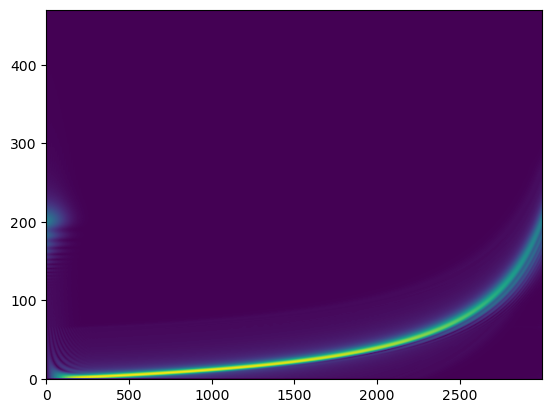

(61, 471, 3000)


In [1]:
# X. Li 2022 - 2024

import  numpy as np
import  scipy.special
from    typing import Union, Optional

sqrt2pi = np.sqrt(2*np.pi)
sqrt1pi = np.sqrt(np.pi)

def linear_JCTFT(   ts              : np.ndarray        , 
                    sample_rate     : Union[int, float] , 
                    L               : int,
                    C               : Union[int, float] ,
                    frange          : Union[list[int, int]]       = [30, 300]  , 
                    frate           : Union[int, float] = 1         , 
                    alpha           : int               = 1         ,
                    downsample      : Optional[int]     = None      ,
                    win_template    : Optional[np.ndarray]        = None
                    ) -> np.ndarray:
    '''Compute the Linear Joint Chirp Rate Time Frequency Transform of a time 
    series data array

    Parameters
    ----------
    ts (np.ndarray)         : time series data array
    sample_rate (int)       : sample rate of the time series
    L (int)                 : the number of chirp rate parameters
    C (int, float)          : chirp rate scaling coefficient
    frange (list[int, int]) : frequency range to compute the S Transform
    frate (int)             : frequency resolution of the S Transform
    alpha (int)             : normalization factor for the Gaussian window
    downsample (int)        : downsample factor for the S Transform
    win_template (np.ndarray): window template for the S Transform

    Returns
    -------
    vol (np.ndarray)        : linear JCTFT spectrogram array

    NOTE:
    * Each Time-Frequency spectrogram is computed using the S Transform
    * Refer to the S Transform for more details
    '''

    # see the S Transform for more details
    # https://github.com/xli2522/S-Transform
    length          : int           = len(ts)       # length of the input ts
    Nfreq           : list[int, int]= [int(frange[0]*length/sample_rate), 
                                        int(frange[1]*length/sample_rate)]
    tsVal           : np.ndarray    = np.copy(ts)   # copy of the input ts

    # number of freq bins
    number_freq     : int           = abs(int(Nfreq[1] - Nfreq[0]))  

    _scaled_frate   : int           = int(np.ceil(frate*length/sample_rate)) 

    # FFT of the original time series
    tsFFT           : np.ndarray    = np.fft.fft(tsVal)

    # time domain downsampling
    if downsample   ==  None:
        tsFFT_cut   : np.ndarray    = np.concatenate((tsFFT, tsFFT))
        downsampled_length          : int       = len(tsFFT)
        normalize_cut               : int       = 1

    elif isinstance(downsample, int):
        # positive half
        tsFFT_positive              : np.ndarray= tsFFT[:Nfreq[1]]             
        # negative half   
        tsFFT_negative              : np.ndarray= tsFFT[-Nfreq[1]:len(tsFFT)]     
        if downsample < 2*number_freq:
            # perform the max allowed lower and higher frequency cut-off
            pass
        else:
            # 0 padding to make up for the high and low-passed freq elements
            tsFFT_positive          : np.ndarray= np.concatenate((
                tsFFT_positive, 
                np.zeros(downsample//2-number_freq)
                ))  

            tsFFT_negative          : np.ndarray= np.concatenate((
                np.zeros(downsample//2-number_freq), 
                tsFFT_negative
                ))

        # connect high and low-passed coefficients
        tsFFT_cut   : np.ndarray    = np.concatenate(
            (tsFFT_positive, tsFFT_negative))
        downsampled_length          : int       = len(tsFFT_cut)

        # normalization factor
        normalize_cut = 1 - downsampled_length/length

    # prepare the stacked vector for the S Transform convolution operation
    vec             : np.ndarray    = np.hstack((tsFFT_cut, tsFFT_cut))      
    # vec             : np.ndarray    = tsFFT_cut

    volume          : np.ndarray    = np.zeros(
                    ( 2*L + 1, 
                      int(number_freq/_scaled_frate)+1,
                      downsampled_length
                    ), dtype='c8')
    
    # Temporary variable for the frequency scaling, will be removed later
    # BEGIN of temporary variables
    _scaled_sigma   : int           = 30
    mu              : int           = 0.005
    # END of temporary variables

    for l in range(-L, L+1):
        for i in range(_scaled_frate, number_freq+1, _scaled_frate):       
            
            volume[l,
                   int(i/_scaled_frate),
                   :] = np.fft.ifft(
                    vec[Nfreq[0]+i:Nfreq[0]+i+downsampled_length]
                    *linear_freq_win(downsampled_length, 
                                     Nfreq, 
                                     l*C,_scaled_sigma+mu*i)*normalize_cut)
    # final IFFT with rescaled amplitudes
    # volume = np.fft.ifft(volume*normalize_cut)
    # here we add the average values to the 0th row
    volume[0,0,:] = np.mean(ts)*np.ones(volume[0,0,:].shape)

    return volume


def linear_freq_win(length, _scaled_frange, _scaled_gamma, _scaled_freq,
                        amp=1):
    '''The frequency domain linear chirp window function.
    Inputs:
            length              length of the window function
            _scaled_frange      frequency range (in frequency number)
            _scaled_gamma       chirp rate gamma
            _scaled_freq        frequency STD control parameter
            amp                 amplitude scaling parameter 
    Output:
            win        window function template  
    Note:
            discrete frequency number and time number refer to discrete bin 
            numbers 
    '''
    # discrete frequency scale in frequency number
    alpha = np.linspace(-_scaled_frange[1], 
	                    	_scaled_frange[1], length)

    # determine frequency number and chirp rate number
    _scaled_freq = _scaled_freq/length*_scaled_frange[1]*2
    _scaled_gamma = _scaled_gamma/length*_scaled_frange[1]*2

    # parameters for the complex frequency domain JCTFT window function

    c = _scaled_freq**2/2; d = 2*np.pi*_scaled_gamma 
    k = c+1j*d; sqrtk = np.sqrt(k)

    A = _scaled_freq/sqrt2pi            # partial normalization factor

    # the v4 window with signed gamma (minor changes expected)
    win = amp*A*(np.exp(-np.pi**2*alpha**2/k)*sqrt1pi/2/sqrtk*
                            (1-scipy.special.erf(1j*np.pi*alpha/sqrtk)))

    win = np.nan_to_num(win)		# slow		
    # reshape the window function to match the JCTFT computation procedure
    win = np.hstack((win,win))[length//2:length//2+length]

    return win

def _test_linear():

    import time
    rate = 2048; t = 3; length = rate*t
    ts = np.linspace(0, t, rate*t)
    #signal = np.exp(1j*(60*ts+30*ts**2)).real
    import scipy.signal
    signal = scipy.signal.chirp(ts, 30, t, 250, method='hyperbolic')
    L=30; C=1; frange=[30,500]; downsample=300; frate=1
    begin_temp = time.time()

    volume = linear_JCTFT(signal, rate, 
                 L, C, frange, frate, 1, downsample)
    print('Time elapsed:', time.time()-begin_temp)

    import matplotlib.pyplot as plt
    #from mpl_toolkits.mplot3d import Axes3D

    plt.imshow(np.abs(volume[20,:,:]), aspect='auto', origin='lower')
    plt.show()
    
    print(volume.shape)
    
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    
    #L_dim, freq_dim, time_dim = volume.shape
    #X, Y, Z = np.meshgrid(range(time_dim), range(freq_dim), range(L_dim))

    
    #ax.scatter(X, Y, Z, c=np.abs(volume).flatten(), cmap='viridis')
    
    #ax.set_xlabel('Time')
    #ax.set_ylabel('Frequency')
    #ax.set_zlabel('Chirp Rate')
    
    #plt.show()

if __name__ == '__main__':
    _test_linear()
    
#Downsample resolving
#Width of window function to be changed if needed

In [2]:
import time
import h5py
import pandas as pd
k=1
while(k<=708):
    
    file_path = '/home/arutkeerthi/Downloads/Glitchveto/Glitches_data/Glitch{}.hdf5'.format(k)
    with h5py.File(file_path, 'r') as f:
        strain_data = f['strain/Strain'][:]
        time_div = f['strain/Strain'].attrs['Xspacing']
        div = f['strain/Strain'].attrs['Npoints']
        toa = f['strain/Strain'].attrs['toa']

    # Calculate the indices for the 3 seconds before and after the toa point
    if(toa<=3):
        start_index = 0
        end_index = int(6 / time_div)
    else:
        toa_index = int((toa) / time_div)
        start_index = toa_index - int(3/time_div)
        end_index = toa_index +int(3/time_div)

    # Clip the strain data
    clipped_strain_data = strain_data[start_index:end_index]

    rate = int(1/time_div)
    t = 3
    length = div    
    #ts = np.linspace(0, t, length)
    L = 30
    C = 1
    frange = [30, 500]
    downsample = 1000
    frate = 1
    
    begin_temp = time.time()
    volume = linear_JCTFT(clipped_strain_data, rate, L, C, frange, frate, 1, downsample)
    print('Time elapsed:', time.time()-begin_temp)

    volume=np.abs(volume)
    print(volume.shape)
    positive_chirp=volume[31:60]
    negative_chirp=volume[0:29]

    # Parameters for histogram
    num_bins = 100  # Number of bins for the histogram

    # Function to compute histogram for a 2D slice
    def compute_histogram(slice_2d, bins):
        hist, bin_edges = np.histogram(slice_2d, bins=bins)
        return hist, bin_edges

    def histogram_df(volume, num_bins):
        # List to store DataFrames for each slice
        hist_list = []
        histogram_df=pd.DataFrame({'slice_index','bin_start','bin_end','count'})
        
        # Iterate over each slice and compute histogram
        for i in range(volume.shape[0]):
            slice_2d = volume[i, :, :]
            hist, bin_edges = compute_histogram(slice_2d, num_bins)
            
            # Prepare data for this slice
            slice_hist_df = pd.DataFrame({
                'slice_index': i,
                'bin_start': bin_edges[:-1],
                'bin_end': bin_edges[1:],
                'count': hist
            })
            
            # Append the DataFrame to the list
            hist_list.append(slice_hist_df)
        
        # Concatenate all slice DataFrames into a single DataFrame
        histogram_df = pd.concat(hist_list, ignore_index=True)
        
        return histogram_df

    positive_df=histogram_df(positive_chirp,num_bins)
    positive_df.to_csv('/home/arutkeerthi/Downloads/Glitchveto/Glitch_volumes/positive_{}.csv'.format(k), index=False)

    negative_df=histogram_df(negative_chirp,num_bins)
    # Save to CSV
    negative_df.to_csv('/home/arutkeerthi/Downloads/Glitchveto/Glitch_volumes/negative_{}.csv'.format(k), index=False)

    print(clipped_strain_data.shape)
    print('{}-csv-updates'.format(k))
    k=k+1



/tmp/ipykernel_2273/172314764.py:158: RuntimeWarning: invalid value encountered in multiply
  win = amp*A*(np.exp(-np.pi**2*alpha**2/k)*sqrt1pi/2/sqrtk*


Time elapsed: 37.30119514465332
(61, 471, 6000)
(24576,)
359-csv-updates
Time elapsed: 37.60832738876343
(61, 471, 6000)
(24576,)
360-csv-updates
Time elapsed: 37.48981165885925
(61, 471, 6000)
(24576,)
361-csv-updates
Time elapsed: 37.13440752029419
(61, 471, 6000)
(24576,)
362-csv-updates
Time elapsed: 38.13067889213562
(61, 471, 6000)
(24576,)
363-csv-updates
Time elapsed: 37.03007936477661
(61, 471, 6000)
(24576,)
364-csv-updates
Time elapsed: 37.41325640678406
(61, 471, 6000)
(24576,)
365-csv-updates
Time elapsed: 37.36249876022339
(61, 471, 6000)
(24576,)
366-csv-updates
Time elapsed: 37.07432699203491
(61, 471, 6000)
(24576,)
367-csv-updates
Time elapsed: 37.647520542144775
(61, 471, 6000)
(24576,)
368-csv-updates
Time elapsed: 37.57616949081421
(61, 471, 6000)
(24576,)
369-csv-updates
Time elapsed: 37.530389070510864
(61, 471, 6000)
(24576,)
370-csv-updates
Time elapsed: 37.62273693084717
(61, 471, 6000)
(24576,)
371-csv-updates
Time elapsed: 38.17732214927673
(61, 471, 6000)
(